In [3]:
from binance.spot import Spot
import api
import yfinance as yf
import matplotlib.pyplot as plt
import TechnicalIndicators as TA
import Signals as S
import time
import datetime as dt
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, Bounds

# Initialize Binance spot
client = Spot()
client = Spot(key=api.Binance, secret=api.BinanceSecret)

# Converts Binance candlestick data to pandas DataFrame format with correct types and formatted date
def klines_df(Ticker,Time,lim):
    A = client.klines(Ticker,Time,limit=lim)
    for row in A:
        for item in row:
            item = float(item)
        row[0] = dt.datetime.fromtimestamp(float(row[0])/1000)
        for _ in range(6):
            row.pop()
    c = ["Time","Open","High","Low","Close","Volume"]
    df = pd.DataFrame(data=A,columns=c)
    df.Open = df.Open.astype(float)
    df.High = df.High.astype(float)
    df.Low = df.Low.astype(float)
    df.Close = df.Close.astype(float)
    df.Volume = df.Volume.astype(float)
    return df

In [4]:
def Balance(x,DF):
    df = DF.copy()
    P = df.Close.to_list()
    balance = 0
    money = 0
    Buy = []
    Sell = []
    Sig = []
    for i, row in df.iterrows():
        s = 0
        for j in range(0,len(x)):
            s += x[j] * row[7+j]
        Sig.append(s)
        # if (s <= -1):
        #     Buy.append(P[i])
        # elif (s >= 1):
        #     Sell.append(P[i])
    return np.average(P,weights=Sig)

In [5]:
# df = klines_df("BTCUSDT","1d",1000)
# df.to_csv("BTCUSDT.csv")
# df.head
# df = pd.read_csv("data/BTCUSDT5m.csv")
# df.head

In [19]:
df = pd.read_csv("data/BTCUSDT1h.csv")
df["BBsignal12"] = S.BB(df,12,1)
df["BBsignal24"] = S.BB(df,24,1)
df["BBsignal48"] = S.BB(df,48,1)
df["RSIsignal12"] = S.RSI(df,12)
df["RSIsignal24"] = S.RSI(df,24)
df["RSIsignal48"] = S.RSI(df,48)
df["eMAsignal12"] = S.eMA(df,12)
df["eMAsignal24"] = S.eMA(df,24)
df["eMAsignal48"] = S.eMA(df,48)
df.dropna(inplace=True)
df.drop(["RSI","RSIsignal","eMA","eMAsignal"],axis=1,inplace=True)
df.head()

,Unnamed: 0,Time,Open,High,Low,Close,Volume,BBsignal12,BBsignal24,BBsignal48,RSIsignal12,RSIsignal24,RSIsignal48,eMAsignal12,eMAsignal24,eMAsignal48
94,94,2021-07-07 15:00:00,34853.85,34881.55,34635.43,34813.22,1906.713965,0.0,1.0,1.0,0,0,0,1,1,1
95,95,2021-07-07 16:00:00,34813.22,34874.99,34532.50,34616.60,2215.052981,0.0,1.0,1.0,0,0,0,-1,1,1
96,96,2021-07-07 17:00:00,34616.60,34696.64,34477.13,34528.60,2098.341327,0.0,1.0,1.0,0,0,0,-1,1,1
97,97,2021-07-07 18:00:00,34528.60,34629.96,34412.43,34571.38,1574.335915,0.0,1.0,1.0,0,0,0,-1,1,1
98,98,2021-07-07 19:00:00,34571.37,34689.29,34470.00,34635.01,1243.169797,0.0,1.0,1.0,0,0,0,1,1,1


In [88]:
B = Bounds((-1,-1,-1,-1,-1,-1,-1,-1,-1),(1,1,1,1,1,1,1,1,1))
result = differential_evolution(Balance,bounds=B,args=(df,),disp=True,maxiter=1000)
print(result)

differential_evolution step 1: f(x)= -415047
differential_evolution step 2: f(x)= -4.28915e+06
differential_evolution step 3: f(x)= -4.28915e+06
differential_evolution step 4: f(x)= -4.28915e+06
differential_evolution step 5: f(x)= -4.28915e+06
differential_evolution step 6: f(x)= -4.28915e+06
differential_evolution step 7: f(x)= -4.28915e+06
differential_evolution step 8: f(x)= -4.28915e+06
differential_evolution step 9: f(x)= -4.28915e+06
differential_evolution step 10: f(x)= -4.28915e+06
differential_evolution step 11: f(x)= -4.28915e+06
differential_evolution step 12: f(x)= -4.28915e+06
differential_evolution step 13: f(x)= -4.28915e+06
differential_evolution step 14: f(x)= -4.28915e+06
differential_evolution step 15: f(x)= -4.28915e+06
differential_evolution step 16: f(x)= -4.28915e+06
differential_evolution step 17: f(x)= -4.28915e+06
differential_evolution step 18: f(x)= -4.28915e+06
differential_evolution step 19: f(x)= -4.28915e+06
differential_evolution step 20: f(x)= -4.2891

<AxesSubplot:>

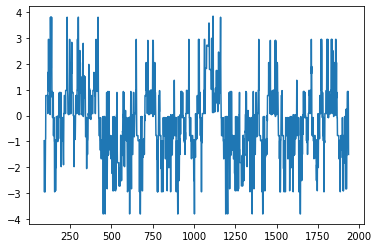

In [20]:
Sig = []
P = df.Close.to_list()
y = [ 0.89883702, -0.03933714, -0.97400998, -0.69797414, -0.56891254,-0.48236657,  0.98930961, -0.64743158, -0.30602044]
T = []

Sig = []
for i, row in df.iterrows():
    s = 0
    for j in range(0,len(y)):
        s += y[j] * row[7+j]
    Sig.append(s)
df["Signal"] = Sig
df.Signal.plot()

In [22]:
BuyT = []
SellT = []
balance = 0
money = 0
amount = 1
for i in range(0,len(Sig)):
        if (Sig[i] < -2 and balance > 0):
                # Selling order
                SellT.append(P[i])
                money += balance * amount * P[i]
                balance = 0
        elif (Sig[i] > 3):
                # Buying order
                BuyT.append(P[i])
                balance += 1
                money += -amount * P[i]
money += balance * P[i] * amount

print(len(BuyT),len(SellT))
print(np.mean(BuyT),np.mean(SellT))
print(money)

14 2
31997.114999999998 31811.6
-2597.2100000001083
